# PyIndMach012: an example of user-model using DSS-Python

This example runs a modified example from the OpenDSS distribution for the induction machine model with a sample PyIndMach012 implementation, written in Python, and the original, built-in IndMach012.

Check the `PyIndMach012.py` file for more comments. Comparing it to [the Pascal code for IndMach012](https://github.com/dss-extensions/dss_capi/blob/master/Version7/Source/PCElements/IndMach012.pas) can be useful to understand some of the inner workings of OpenDSS.

The user-model code in DSS-Python was supposed to grow other features, but the effort hasn't been continued for many reasons. The code for generator user-models has been stable for many releases. We believe it can be used to develop new ideas before committing the final model in a traditional DLL user-model.

The outputs for this notebook should be listed below, but you can also open and then run this notebook on Google Colab for a quick overview if you don't want to set up a local environment: **[Open in Colab](https://colab.research.google.com/github/dss-extensions/dss_python/blob/master/docs/examples/UserModels/PyIndMach012/README.ipynb)**. The next cell installs DSS-Python and dependencies, and downloads the extra files.

In [1]:
import os, subprocess
if os.getenv("COLAB_RELEASE_TAG"):
    import urllib.request
    print(subprocess.check_output('pip install dss-python[plot]', shell=True).decode())
    urllib.request.urlretrieve("https://raw.githubusercontent.com/dss-extensions/dss_python/master/docs/examples/UserModels/PyIndMach012/PyIndMach012.py", "PyIndMach012.py")
    urllib.request.urlretrieve("https://raw.githubusercontent.com/dss-extensions/dss_python/master/docs/examples/UserModels/PyIndMach012/master.dss", "master.dss")


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from dss.UserModels import GenUserModel # used to get the DLL path
import PyIndMach012 # we need to import the model so it gets registered

## The model class

Run `??PyIndMach012` to see the code of the class, or open `PyIndMach012.py` in an editor.

In [15]:
with open('PyIndMach012.py', 'r') as f:
    src = f.read()

print(src)

'''
A `dss_python` User-Model implementation of the IndMach012 Generator model from OpenDSS.

Based on the following files from the official OpenDSS source code:
- Source/PCElements/IndMach012.pas
- Source/IndMach012a/IndMach012Model.pas

This Python version was written by Paulo Meira. 
Original code by EPRI, licensed under the 3-clause BSD. See OPENDSS_LICENSE.

This sample code doesn't interact with the main OpenDSS interface directly,
it only uses the user-model interface. Thus, it is compatible with the official OpenDSS
distribution as well as DSS-Python. Note that OpenDSS version 7 has a bug on 64-bit 
systems and user-models most likely won't run via COM.

Recent version of OpenDSS 8 also present a bug when handling the editing of 
user-model parameters after the creation of the generator. You can, of course,
edit the data in Python if you desire.

'''
from dss.UserModels import GenUserModel
from dss.enums import SolveModes
import numpy as np

# This is the user-model we'll use a

## OpenDSS setup

For this example, we can use either COM or DSS-Python (DSS C-API).

In [4]:
original_dir = os.getcwd() # same the original working directory since the COM module messes with it
USE_COM = False # toggle this value to run with DSS C-API or COM
if USE_COM:
    from dss import patch_dss_com
    import comtypes.client
    DSS = patch_dss_com(comtypes.client.CreateObject('OpenDSSengine.DSS'))
    DSS.DataPath = original_dir
    os.chdir(original_dir)
else:
    from dss import DSS
    
DSS.Version    

'DSS C-API Library version DEV revision UNKNOWN based on OpenDSS SVN UNKNOWN [FPC 3.2.2] (64-bit build) MVMULT INCREMENTAL_Y CONTEXT_API PM 20240209064406; License Status: Open \nDSS-Python version: 0.15.0rc1'

In [5]:
Text = DSS.Text
Monitors = DSS.ActiveCircuit.Monitors

## Using the model

To use a Python model for generators:
- the model class needs to be registered in advance
- create a generator with `model=6`
    - pass a `usermodel="{dll_path}"` as in the following DSS command in the `run` function
    - pass a `"pymodel=MODELNAME"` parameter in the userdata property, where MODELNAME is the name of the model class in Python


In [10]:
def run(pymodel):
    Text.Command = 'redirect "master.dss"'

    if pymodel:
        # This uses our custom user-model in Python
        Text.Command = 'New "Generator.Motor1" bus1=Bg2 kW=1200 conn=delta kVA=1500.000 H=6 model=6 kv=0.48 D=0 usermodel="{dll_path}" userdata=(pymodel=PyIndMach012 purs=0.048 puxs=0.075 purr=0.018 puxr=0.12 puxm=3.8 slip=0.02 SlipOption=variableslip)'.format(
            dll_path=GenUserModel.dll_path,
        )
        Text.Command = 'New "Monitor.mfr2" element=Generator.Motor1 terminal=1 mode=3'
    else:
        # This uses the built-in model for comparison
        Text.Command = 'New "IndMach012.Motor1" bus1=Bg2 kW=1200 conn=delta kVA=1500.000 H=6 purs=0.048 puxs=0.075 purr=0.018 puxr=0.12 puxm=3.8 slip=0.02 SlipOption=variableslip kv=0.48'
        Text.Command = 'New "Monitor.mfr2" element=IndMach012.Motor1 terminal=1 mode=3'
        
    # This will run a power-flow solution
    Text.Command = 'Solve'
    
    # This will toggle to the dynamics mode
    Text.Command = 'Set mode=dynamics number=1 h=0.000166667'
    
    # And finally run 5000 steps for the dynamic simulation
    Text.Command = f'Solve number=5000'
   

In [11]:
# There are the channels from the Pascal/built-in IndMach012
channels_pas = ('Frequency', 'Theta (deg)', 'E1', 'dSpeed (deg/sec)', 'dTheta (deg)', 'Slip', 'Is1', 'Is2', 'Ir1', 'Ir2', 'Stator Losses', 'Rotor Losses', 'Shaft Power (hp)', 'Power Factor', 'Efficiency (%)')

# There are the channels from the Python module -- we define part of these and part come from the generator model itself
channels_py = ('Frequency', 'Theta (Deg)', 'E1_pu', 'dSpeed (Deg/sec)', 'dTheta (Deg)', 'Slip', 'Is1', 'Is2', 'Ir1', 'Ir2', 'StatorLosses', 'RotorLosses', 'ShaftPower_hp', 'PowerFactor', 'Efficiency_pct')

## Running and saving the outputs

Let's run the Pascal/built-in version of IndMach012 and our custom Python version for comparison:

In [12]:
run(False)
Monitors.Name = 'mfr2'
header = [x.strip() for x in Monitors.Header]
outputs_pas = {channel: Monitors.Channel(header.index(channel) + 1) for channel in channels_pas}

run(True)
Monitors.Name = 'mfr2'
header = [x.strip() for x in Monitors.Header]
outputs_py = {channel: Monitors.Channel(header.index(channel) + 1) for channel in channels_py}

time = np.arange(1, 5000 + 1) * 0.000166667
offset = int(0.1 / 0.000166667)

## Plotting the various output channels

The example circuit applies a fault at 0.3 s, isolating the machine at 0.4s (check `master.dss` for more details).

As we can see from the figures below, the outputs match very closely. After the induction machine is isolated, the efficiency and power factor values can misbehave as the power goes to zero, seem especially in the Pascal version.

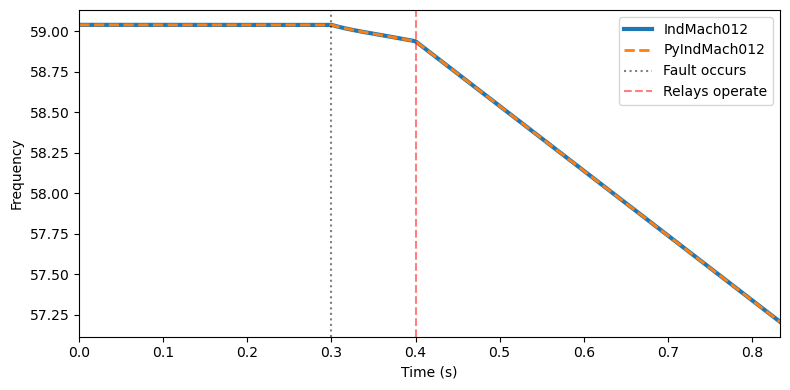

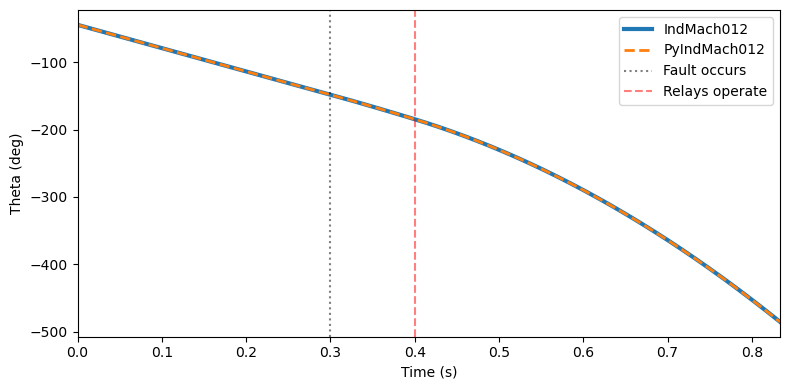

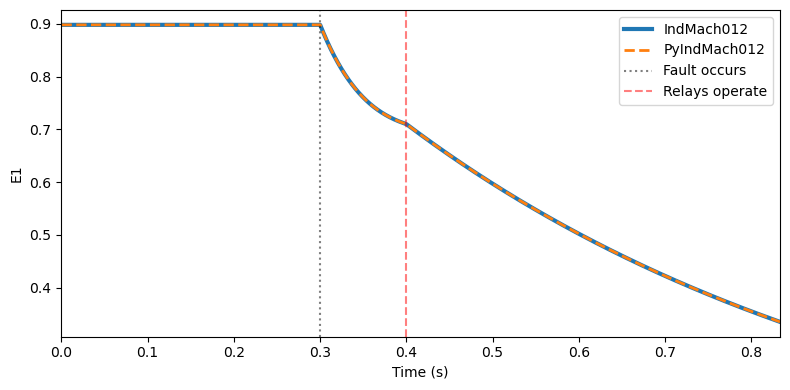

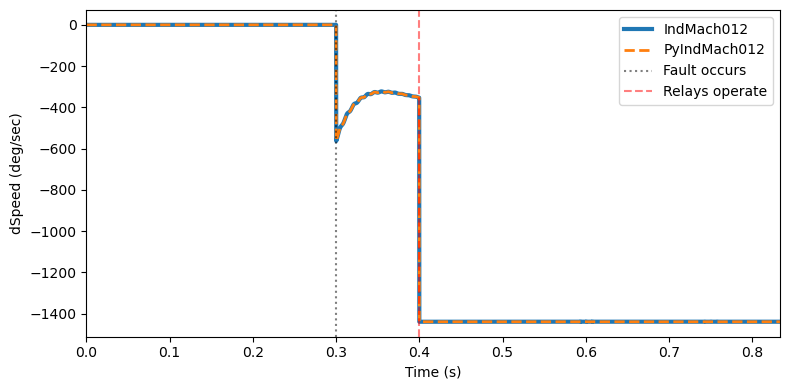

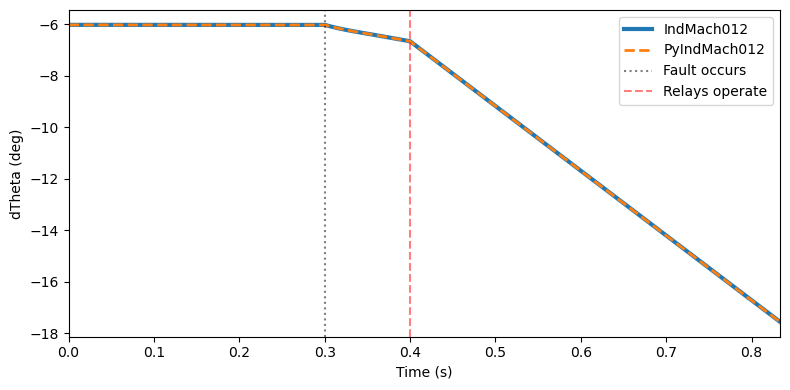

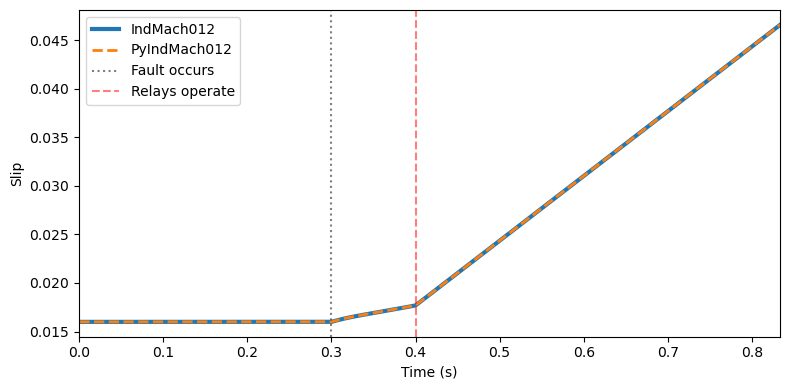

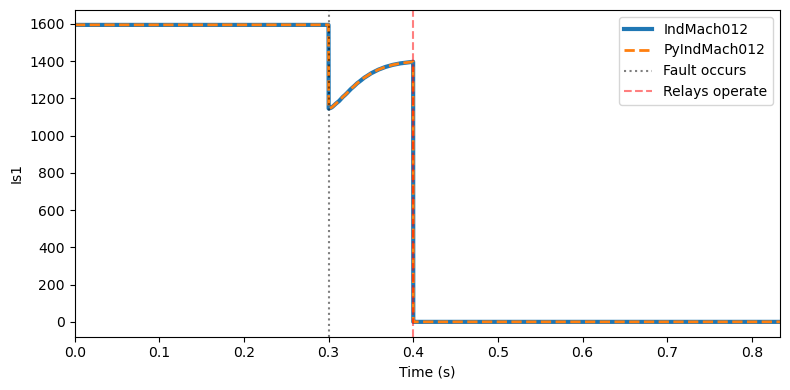

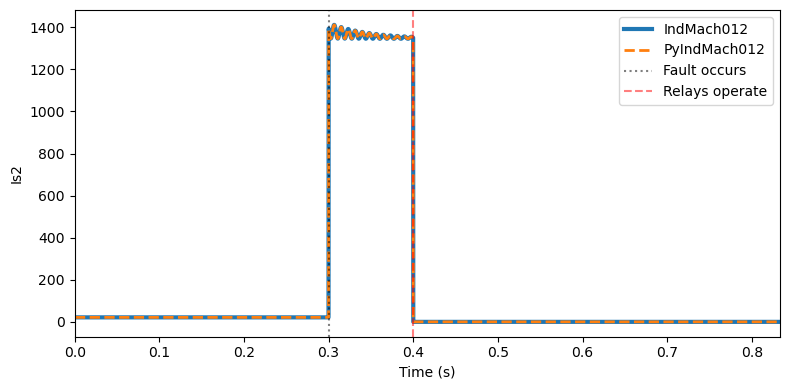

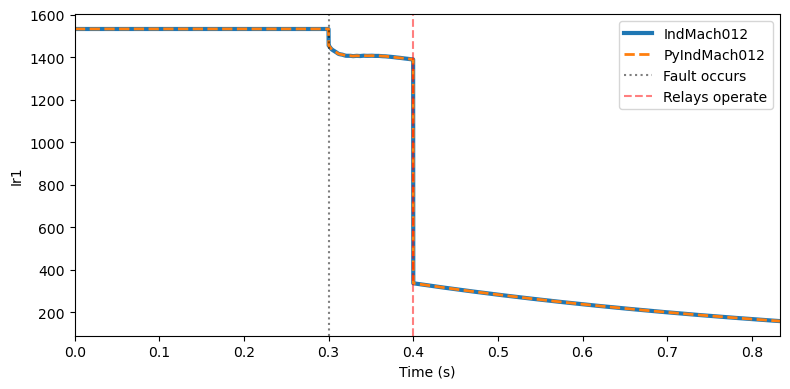

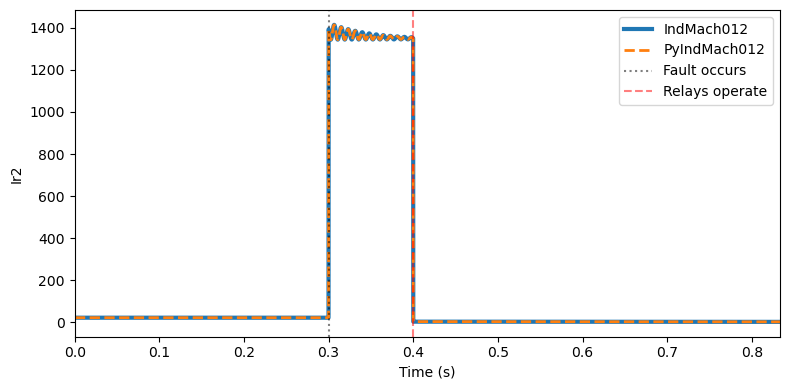

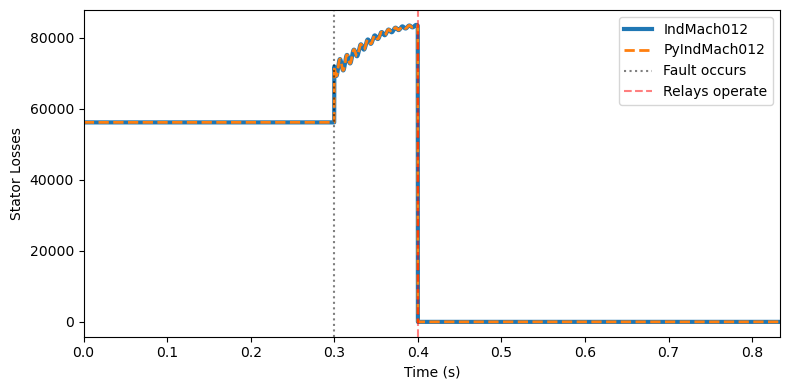

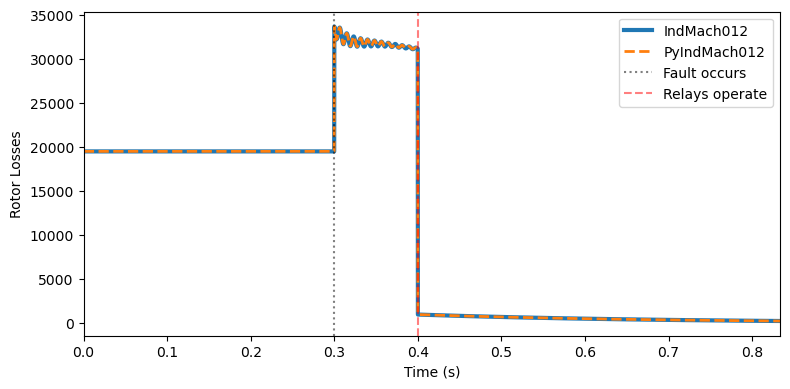

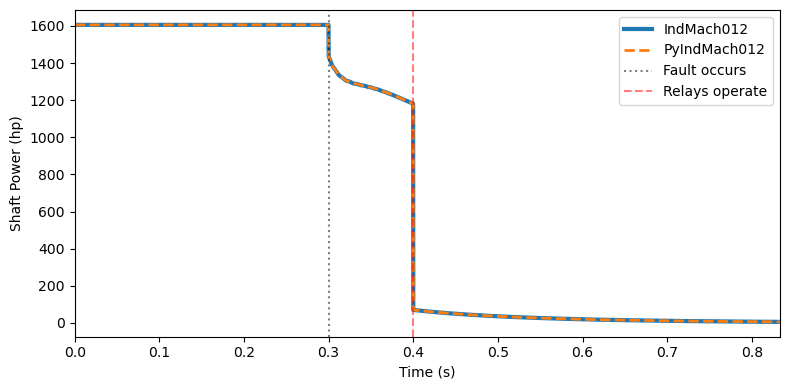

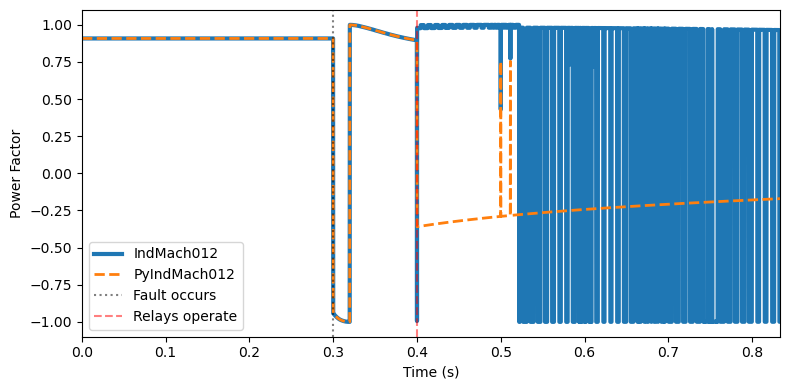

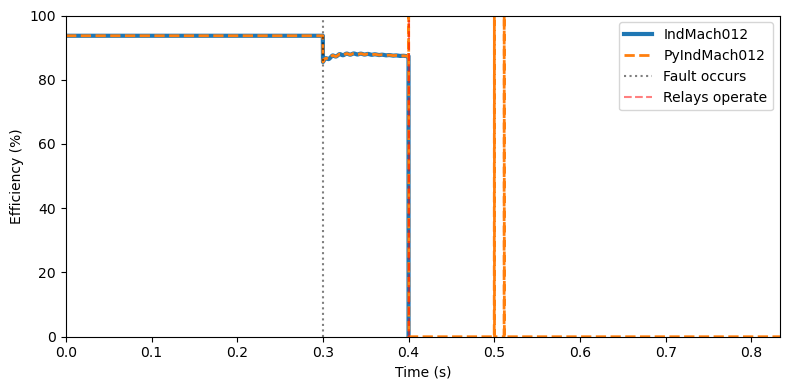

In [13]:
for ch_pas, ch_py in zip(channels_pas, channels_py):
    plt.figure(figsize=(8,4))
    plt.plot(time, outputs_pas[ch_pas], label='IndMach012', lw=3)
    plt.plot(time, outputs_py[ch_py], label='PyIndMach012', ls='--', lw=2)
    plt.axvline(0.3, linestyle=':', color='k', alpha=0.5, label='Fault occurs')
    plt.axvline(0.4, linestyle='--', color='r', alpha=0.5, label='Relays operate')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel(ch_pas)
    
    if ch_pas == 'Efficiency (%)':
        # Limit efficiency to 0-100
        plt.ylim(0, 100)
        
    plt.xlim(0, time[-1])
    plt.tight_layout()
    